In [1]:
#!pip install mysqlclient
#!pip install bellmanford
#!pip install networkx

In [2]:
from OrderbookAnalyser import OrderbookAnalyser

In [3]:
runLocal = True

if runLocal == False:
    host="orderbook.cyifbgm0zwt0.eu-west-2.rds.amazonaws.com"
    user="admin"
    passwd="123Qwe123Qwe"
    db="orderbook"
    port=3306
else:
    host="127.0.0.1"
    user="admin"
    passwd="admin"
    db="orderbook"
    port=33306

orderbookAnalyser = OrderbookAnalyser(host,user,passwd,db,port)

exchangeList = ['coinfloor','kraken','bitfinex','bittrex','gdax','bitstamp','coinbase','poloniex']
vol_BTC = 0.15
df=orderbookAnalyser.runSim(exchangeList=exchangeList,limit=10000,vol_BTC=vol_BTC)

3it [00:00, 22.97it/s]

Rows fetched: 10000


30it [00:00, 59.03it/s]

*** TypeError error ***


45it [00:00, 73.72it/s]

*** TypeError error ***


112it [00:01, 59.16it/s]

*** TypeError error ***


168it [00:02, 61.04it/s]

*** TypeError error ***


194it [00:03, 62.89it/s]

*** TypeError error ***


252it [00:03, 65.60it/s]

*** TypeError error ***


271it [00:04, 65.87it/s]

*** TypeError error ***
*** TypeError error ***


331it [00:04, 67.35it/s]

*** TypeError error ***
*** TypeError error ***


438it [00:06, 69.24it/s]

*** TypeError error ***


463it [00:06, 67.10it/s]

*** TypeError error ***
*** TypeError error ***


492it [00:07, 67.06it/s]

*** TypeError error ***


558it [00:08, 67.38it/s]

*** TypeError error ***


567it [00:08, 67.27it/s]

*** TypeError error ***


633it [00:09, 65.92it/s]

*** TypeError error ***


682it [00:10, 64.97it/s]

*** TypeError error ***
*** TypeError error ***


714it [00:10, 65.46it/s]

*** TypeError error ***


759it [00:11, 64.76it/s]

*** TypeError error ***
*** TypeError error ***


781it [00:11, 65.17it/s]

*** TypeError error ***
*** TypeError error ***


835it [00:12, 64.84it/s]

*** TypeError error ***
*** TypeError error ***


920it [00:14, 63.82it/s]

*** TypeError error ***


972it [00:15, 63.63it/s]

*** TypeError error ***
*** TypeError error ***


1002it [00:15, 63.99it/s]

*** TypeError error ***


1055it [00:16, 63.42it/s]

*** TypeError error ***


1064it [00:16, 63.56it/s]

*** TypeError error ***


1137it [00:17, 63.32it/s]

*** TypeError error ***


1175it [00:18, 62.95it/s]

*** TypeError error ***


1210it [00:19, 63.19it/s]

*** TypeError error ***


1251it [00:20, 62.37it/s]

*** TypeError error ***
*** TypeError error ***


1268it [00:20, 62.19it/s]

*** TypeError error ***
*** TypeError error ***


1312it [00:21, 61.73it/s]

*** TypeError error ***


1330it [00:21, 61.68it/s]

*** TypeError error ***


1431it [00:23, 62.09it/s]

*** TypeError error ***
*** TypeError error ***


1455it [00:23, 61.57it/s]

*** TypeError error ***
*** TypeError error ***


1482it [00:24, 61.56it/s]

*** TypeError error ***


1538it [00:25, 61.46it/s]

*** TypeError error ***


1568it [00:25, 61.59it/s]

*** TypeError error ***


1628it [00:26, 61.31it/s]

*** TypeError error ***


1667it [00:27, 61.17it/s]

*** TypeError error ***


1696it [00:27, 61.17it/s]

*** TypeError error ***


1740it [00:28, 61.01it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


1761it [00:28, 61.14it/s]

*** TypeError error ***


1803it [00:29, 61.00it/s]

*** TypeError error ***


1821it [00:29, 61.06it/s]

*** TypeError error ***


1919it [00:31, 61.05it/s]

*** TypeError error ***


1947it [00:31, 60.88it/s]

*** TypeError error ***
*** TypeError error ***


1974it [00:32, 60.98it/s]

*** TypeError error ***


2029it [00:33, 60.88it/s]

*** TypeError error ***


2054it [00:33, 60.92it/s]

*** TypeError error ***


2126it [00:34, 60.76it/s]

*** TypeError error ***


2156it [00:35, 60.72it/s]

*** TypeError error ***


2199it [00:36, 60.65it/s]

*** TypeError error ***


2248it [00:37, 60.48it/s]

*** TypeError error ***
*** TypeError error ***


2264it [00:37, 60.47it/s]

*** TypeError error ***
*** TypeError error ***


2320it [00:38, 60.33it/s]

*** TypeError error ***


2412it [00:40, 60.12it/s]

*** TypeError error ***
*** TypeError error ***


2444it [00:40, 60.17it/s]

*** TypeError error ***
*** TypeError error ***


2476it [00:41, 59.89it/s]

*** TypeError error ***


2532it [00:42, 59.66it/s]

*** TypeError error ***


2557it [00:42, 59.66it/s]

*** TypeError error ***


2621it [00:43, 59.62it/s]

*** TypeError error ***


2651it [00:44, 59.66it/s]

*** TypeError error ***


2695it [00:45, 59.66it/s]

*** TypeError error ***


2729it [00:45, 59.51it/s]

*** TypeError error ***
*** TypeError error ***


2747it [00:46, 59.55it/s]

*** TypeError error ***
*** TypeError error ***


2779it [00:46, 59.64it/s]

*** TypeError error ***


2817it [00:47, 59.53it/s]

*** TypeError error ***


2909it [00:49, 59.02it/s]

*** TypeError error ***


2948it [00:50, 58.83it/s]

*** TypeError error ***
*** TypeError error ***


2973it [00:50, 58.78it/s]

*** TypeError error ***


3027it [00:51, 58.63it/s]

*** TypeError error ***


3054it [00:52, 58.70it/s]

*** TypeError error ***


3118it [00:53, 58.55it/s]

*** TypeError error ***


3151it [00:53, 58.43it/s]

*** TypeError error ***


3184it [00:54, 58.51it/s]

*** TypeError error ***


3222it [00:55, 58.51it/s]

*** TypeError error ***
*** TypeError error ***


3246it [00:55, 58.37it/s]

*** TypeError error ***
*** TypeError error ***


3280it [00:56, 58.51it/s]

*** TypeError error ***


3294it [00:56, 58.29it/s]

*** TypeError error ***


3313it [00:56, 58.33it/s]

*** TypeError error ***


3393it [00:57, 58.80it/s]

*** TypeError error ***
*** TypeError error ***


3438it [00:58, 58.96it/s]

*** TypeError error ***
*** TypeError error ***


3456it [00:58, 58.89it/s]

*** TypeError error ***


3510it [00:59, 58.91it/s]

*** TypeError error ***


3534it [00:59, 58.95it/s]

*** TypeError error ***


3602it [01:00, 59.12it/s]

*** TypeError error ***


3640it [01:01, 59.31it/s]

*** TypeError error ***
*** TypeError error ***


3664it [01:01, 59.26it/s]

*** TypeError error ***


3708it [01:02, 59.46it/s]

*** TypeError error ***
*** TypeError error ***


3733it [01:02, 59.43it/s]

*** TypeError error ***
*** TypeError error ***


3775it [01:03, 59.60it/s]

*** TypeError error ***


3800it [01:03, 59.55it/s]

*** TypeError error ***


3885it [01:05, 59.68it/s]

*** TypeError error ***


3911it [01:05, 59.87it/s]

*** TypeError error ***
*** TypeError error ***


3940it [01:05, 59.83it/s]

*** TypeError error ***


4005it [01:06, 59.98it/s]

*** TypeError error ***


4029it [01:07, 59.96it/s]

*** TypeError error ***


4100it [01:08, 60.07it/s]

*** TypeError error ***


4122it [01:08, 60.08it/s]

*** TypeError error ***
*** TypeError error ***


4147it [01:08, 60.11it/s]

*** TypeError error ***


4202it [01:09, 60.23it/s]

*** TypeError error ***
*** TypeError error ***


4230it [01:10, 60.28it/s]

*** TypeError error ***
*** TypeError error ***


4251it [01:10, 60.29it/s]

*** TypeError error ***


4285it [01:11, 60.33it/s]

*** TypeError error ***


4372it [01:12, 60.49it/s]

*** TypeError error ***


4421it [01:13, 60.54it/s]

*** TypeError error ***
*** TypeError error ***


4442it [01:13, 60.58it/s]

*** TypeError error ***


4497it [01:14, 60.65it/s]

*** TypeError error ***


4521it [01:14, 60.69it/s]

*** TypeError error ***


4577it [01:15, 60.78it/s]

*** TypeError error ***


4624it [01:16, 60.80it/s]

*** TypeError error ***


4654it [01:16, 60.84it/s]

*** TypeError error ***


4698it [01:17, 60.89it/s]

*** TypeError error ***
*** TypeError error ***


4720it [01:17, 61.01it/s]

*** TypeError error ***
*** TypeError error ***


4755it [01:17, 60.97it/s]

*** TypeError error ***


4779it [01:18, 61.06it/s]

*** TypeError error ***


4883it [01:19, 61.08it/s]

*** TypeError error ***


4905it [01:20, 61.15it/s]

*** TypeError error ***
*** TypeError error ***


4935it [01:20, 61.17it/s]

*** TypeError error ***


4992it [01:21, 61.19it/s]

*** TypeError error ***


5015it [01:21, 61.20it/s]

*** TypeError error ***


5075it [01:22, 61.22it/s]

*** TypeError error ***


5115it [01:23, 61.28it/s]

*** TypeError error ***


5141it [01:23, 61.21it/s]

*** TypeError error ***


5190it [01:24, 61.25it/s]

*** TypeError error ***


5199it [01:24, 61.26it/s]

*** TypeError error ***
*** TypeError error ***


5225it [01:25, 61.24it/s]

*** TypeError error ***


5287it [01:26, 61.33it/s]

*** TypeError error ***


5378it [01:27, 61.38it/s]

*** TypeError error ***
*** TypeError error ***


5411it [01:28, 61.32it/s]

*** TypeError error ***
*** TypeError error ***


5448it [01:28, 61.46it/s]

*** TypeError error ***


5502it [01:29, 61.46it/s]

*** TypeError error ***
*** TypeError error ***


5573it [01:30, 61.54it/s]

*** TypeError error ***


5608it [01:31, 61.50it/s]

*** TypeError error ***


5639it [01:31, 61.59it/s]

*** TypeError error ***


5699it [01:32, 61.66it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


5770it [01:33, 61.75it/s]

*** TypeError error ***
*** TypeError error ***


5850it [01:34, 62.05it/s]

*** TypeError error ***


5888it [01:34, 62.16it/s]

*** TypeError error ***
*** TypeError error ***


5927it [01:35, 62.12it/s]

*** TypeError error ***


5983it [01:36, 62.22it/s]

*** TypeError error ***


6015it [01:36, 62.33it/s]

*** TypeError error ***


6069it [01:37, 62.37it/s]

*** TypeError error ***


6118it [01:38, 62.37it/s]

*** TypeError error ***


6202it [01:39, 62.53it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


6223it [01:39, 62.52it/s]

*** TypeError error ***


6274it [01:40, 62.56it/s]

*** TypeError error ***


6378it [01:41, 62.69it/s]

*** TypeError error ***


6388it [01:41, 62.65it/s]

*** TypeError error ***
*** TypeError error ***


6415it [01:42, 62.67it/s]

*** TypeError error ***


6496it [01:43, 62.77it/s]

*** TypeError error ***
*** TypeError error ***


6566it [01:44, 62.89it/s]

*** TypeError error ***


6625it [01:45, 62.92it/s]

*** TypeError error ***
*** TypeError error ***


6645it [01:45, 62.90it/s]

*** TypeError error ***


6691it [01:46, 62.94it/s]

*** TypeError error ***
*** TypeError error ***


6710it [01:46, 62.93it/s]

*** TypeError error ***
*** TypeError error ***


6747it [01:47, 62.98it/s]

*** TypeError error ***


6773it [01:47, 62.90it/s]

*** TypeError error ***
*** TypeError error ***


6864it [01:48, 63.08it/s]

*** TypeError error ***


6916it [01:49, 63.13it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


6996it [01:50, 63.24it/s]

*** TypeError error ***


7013it [01:50, 63.19it/s]

*** TypeError error ***


7071it [01:52, 63.13it/s]

*** TypeError error ***


7115it [01:52, 63.17it/s]

*** TypeError error ***


7142it [01:53, 63.16it/s]

*** TypeError error ***


7186it [01:53, 63.16it/s]

*** TypeError error ***
*** TypeError error ***


7213it [01:54, 63.18it/s]

*** TypeError error ***
*** TypeError error ***


7240it [01:54, 63.29it/s]

*** TypeError error ***


7270it [01:54, 63.28it/s]

*** TypeError error ***
*** TypeError error ***


7365it [01:56, 63.43it/s]

*** TypeError error ***
*** TypeError error ***


7400it [01:56, 63.42it/s]

*** TypeError error ***
*** TypeError error ***


7423it [01:56, 63.50it/s]

*** TypeError error ***


7484it [01:57, 63.55it/s]

*** TypeError error ***


7503it [01:58, 63.50it/s]

*** TypeError error ***


7584it [01:59, 63.47it/s]

*** TypeError error ***


7629it [02:00, 63.54it/s]

*** TypeError error ***
*** TypeError error ***


7660it [02:00, 63.60it/s]

*** TypeError error ***


7708it [02:01, 63.65it/s]

*** TypeError error ***
*** TypeError error ***


7724it [02:01, 63.71it/s]

*** TypeError error ***
*** TypeError error ***


7753it [02:01, 63.72it/s]

*** TypeError error ***


7786it [02:02, 63.79it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


7873it [02:03, 63.71it/s]

*** TypeError error ***
*** TypeError error ***


7913it [02:04, 63.78it/s]

*** TypeError error ***
*** TypeError error ***


7929it [02:04, 63.68it/s]

*** TypeError error ***


7993it [02:05, 63.66it/s]

*** TypeError error ***


8028it [02:05, 63.75it/s]

*** TypeError error ***


8047it [02:06, 63.70it/s]

*** TypeError error ***


8081it [02:06, 63.74it/s]

*** TypeError error ***


8122it [02:07, 63.76it/s]

*** TypeError error ***


8154it [02:07, 63.83it/s]

*** TypeError error ***


8194it [02:08, 63.79it/s]

*** TypeError error ***
*** TypeError error ***


8222it [02:08, 63.90it/s]

*** TypeError error ***
*** TypeError error ***


8249it [02:09, 63.87it/s]

*** TypeError error ***


8270it [02:09, 63.91it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


8375it [02:10, 63.97it/s]

*** TypeError error ***
*** TypeError error ***


8401it [02:11, 64.04it/s]

*** TypeError error ***
*** TypeError error ***


8431it [02:11, 64.04it/s]

*** TypeError error ***


8489it [02:12, 64.08it/s]

*** TypeError error ***


8520it [02:12, 64.13it/s]

*** TypeError error ***


8572it [02:13, 64.11it/s]

*** TypeError error ***


8613it [02:14, 64.13it/s]

*** TypeError error ***


8646it [02:14, 64.17it/s]

*** TypeError error ***


8691it [02:15, 64.11it/s]

*** TypeError error ***
*** TypeError error ***
*** TypeError error ***


8718it [02:15, 64.18it/s]

*** TypeError error ***


8736it [02:16, 64.12it/s]

*** TypeError error ***


8750it [02:16, 63.91it/s]

*** TypeError error ***
*** TypeError error ***


8775it [02:17, 63.73it/s]

*** TypeError error ***


8850it [02:21, 62.70it/s]

*** TypeError error ***


8859it [02:21, 62.52it/s]

*** TypeError error ***


8891it [02:23, 62.06it/s]

*** TypeError error ***
*** TypeError error ***


8920it [02:24, 61.82it/s]

*** TypeError error ***


8980it [02:26, 61.31it/s]

*** TypeError error ***


9003it [02:27, 61.16it/s]

*** TypeError error ***


9059it [02:29, 60.61it/s]

*** TypeError error ***


9105it [02:31, 60.26it/s]

*** TypeError error ***


9113it [02:31, 60.19it/s]

*** TypeError error ***


9181it [02:34, 59.55it/s]

*** TypeError error ***
*** TypeError error ***


9202it [02:34, 59.39it/s]

*** TypeError error ***
*** TypeError error ***


9239it [02:36, 59.12it/s]

*** TypeError error ***


9256it [02:36, 59.04it/s]

*** TypeError error ***
*** TypeError error ***


9268it [02:37, 58.96it/s]

*** TypeError error ***


9357it [02:40, 58.29it/s]

*** TypeError error ***


9388it [02:41, 58.12it/s]

*** TypeError error ***
*** TypeError error ***


9413it [02:42, 57.95it/s]

*** TypeError error ***


9477it [02:44, 57.51it/s]

*** TypeError error ***


9501it [02:45, 57.36it/s]

*** TypeError error ***


9562it [02:47, 56.97it/s]

*** TypeError error ***


9599it [02:49, 56.78it/s]

*** TypeError error ***


9611it [02:49, 56.70it/s]

*** TypeError error ***


9677it [02:52, 56.21it/s]

*** TypeError error ***
*** TypeError error ***


9699it [02:52, 56.10it/s]

*** TypeError error ***
*** TypeError error ***


9735it [02:54, 55.86it/s]

*** TypeError error ***


9758it [02:55, 55.74it/s]

*** TypeError error ***


9764it [02:55, 55.70it/s]

*** TypeError error ***


9855it [02:58, 55.12it/s]

*** TypeError error ***


9883it [02:59, 55.01it/s]

*** TypeError error ***


9897it [03:00, 54.94it/s]

*** TypeError error ***


9915it [03:00, 54.88it/s]

*** TypeError error ***


9976it [03:02, 54.59it/s]

*** TypeError error ***


9998it [03:03, 54.53it/s]

*** TypeError error ***


10000it [03:03, 54.53it/s]


In [4]:
df.head()

,id,length,profit_perc,nodes,edges_weight,edges_age_s,hops,exchanges_involved,nof_exchanges_involved
0,128063,-0.001442,0.144348,"bitstamp-BTC,bitstamp-USD,gdax-USD,gdax-BTC,bi...","-8.762468000360128,0.0,8.761025558558117,0.0","-1532914923371.777,0,0.0,0",4,"bitstamp,gdax",2
1,128074,-0.001442,0.144348,"bitstamp-BTC,bitstamp-USD,gdax-USD,gdax-BTC,bi...","-8.762468000360128,0.0,8.761025558558117,0.0","-1532914923371.5564,0,0.22067999839782715,0",4,"bitstamp,gdax",2
2,128113,-0.001442,0.144348,"gdax-BTC,bitstamp-BTC,bitstamp-USD,gdax-USD,gd...","0.0,-8.762468000360128,0.0,8.761025558558117","0,-1532914923371.0867,0,0.6905598640441895",4,"bitstamp,gdax",2
3,128140,-0.001442,0.144348,"gdax-BTC,bitstamp-BTC,bitstamp-USD,gdax-USD,gd...","0.0,-8.762468000360128,0.0,8.761025558558117","0,-1532914923370.6777,0,1.099370002746582",4,"bitstamp,gdax",2
4,128142,-0.001442,0.144348,"gdax-BTC,bitstamp-BTC,bitstamp-USD,gdax-USD,gd...","0.0,-8.762468000360128,0.0,8.761025558558117","0,-1532914923370.6384,0,1.1387999057769775",4,"bitstamp,gdax",2


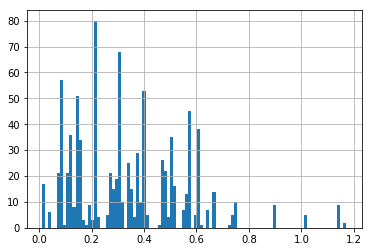

In [5]:
df['profit_perc'].hist(bins=100)

In [6]:
df.to_csv("arbitrage_Vol=%fBTC.csv"%vol_BTC,index=False)